In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from datetime import datetime, timedelta

# Load your dataset
data = pd.read_csv('APPL.withIndicators.withIndicators.csv')

# Drop rows with missing values
data_cleaned = data.dropna()

# Convert the 'Date' column to datetime format with the correct format
data_cleaned.loc[:, 'Date'] = pd.to_datetime(data_cleaned['Date'], format='%d-%m-%Y')

# Calculate the cut-off date for the last 3 years
cutoff_date = datetime.now() - timedelta(days=3*365)

# Filter the data for the last 3 years
recent_data = data_cleaned[data_cleaned['Date'] >= cutoff_date]

# Now you can proceed to use 'recent_data' for training


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Selecting only the specified columns: Date, Close, MACD_Histogram, RSI, OBV, and SMA
data_selected = data_cleaned[['Date', 'Close', 'MACD_Histogram_Val', 'RSI', 'OBV', 'SMA']]

# Renaming columns for consistency and clarity
data_selected = data_selected.rename(columns={
    'MACD_Histogram_Val': 'MACD_Histogram',
    'Close': 'Close_Price'
})

# Display the first few rows of the cleaned and selected dataset
data_selected.head()

,Date,Close_Price,MACD_Histogram,RSI,OBV,SMA
49,1981-02-24 00:00:00,0.106027,-0.001339,31.325417,-213785600.0,0.132578
50,1981-02-25 00:00:00,0.112723,-0.000855,34.482676,-194297600.0,0.132266
51,1981-02-26 00:00:00,0.114397,-0.000346,36.666453,-183456000.0,0.132120
52,1981-02-27 00:00:00,0.118304,0.000297,40.625703,-168694400.0,0.132232
53,1981-03-02 00:00:00,0.118862,0.000774,47.059075,-156934400.0,0.132299


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device
data = data_selected

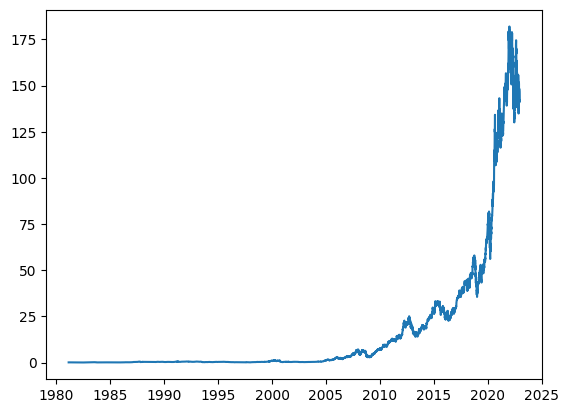

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close_Price'])

In [7]:
from copy import deepcopy as dc

# Function to prepare the dataframe with lookback steps for multiple columns
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)

    # Create shifted values for each specified column
    columns_to_shift = ['Close_Price', 'MACD_Histogram', 'RSI', 'OBV', 'SMA']
    for col in columns_to_shift:
        for i in range(1, n_steps + 1):
            df[f'{col}(t-{i})'] = df[col].shift(i)

    df.dropna(inplace=True)
    return df

# Set the lookback period
lookback = 7

# Prepare the dataframe with lookback steps for each specified column
shifted_df = prepare_dataframe_for_lstm(data_selected, lookback)
shifted_df.head()

,Close_Price,MACD_Histogram,RSI,OBV,SMA,Close_Price(t-1),Close_Price(t-2),Close_Price(t-3),Close_Price(t-4),Close_Price(t-5),...,OBV(t-5),OBV(t-6),OBV(t-7),SMA(t-1),SMA(t-2),SMA(t-3),SMA(t-4),SMA(t-5),SMA(t-6),SMA(t-7)
Date,,,,,,,,,,,,,,,,,,,,,
1981-03-05,0.115513,0.001031,48.780594,-192192000.0,0.131730,0.116071,0.117188,0.118862,0.118304,0.114397,...,-183456000.0,-194297600.0,-213785600.0,0.132065,0.132266,0.132299,0.132232,0.132120,0.132266,0.132578
1981-03-06,0.114397,0.000948,50.632850,-203795200.0,0.131261,0.115513,0.116071,0.117188,0.118862,0.118304,...,-168694400.0,-183456000.0,-194297600.0,0.131730,0.132065,0.132266,0.132299,0.132232,0.132120,0.132266
1981-03-09,0.105469,0.000321,38.889780,-219116800.0,0.130469,0.114397,0.115513,0.116071,0.117188,0.118862,...,-156934400.0,-168694400.0,-183456000.0,0.131261,0.131730,0.132065,0.132266,0.132299,0.132232,0.132120
1981-03-10,0.100446,-0.000366,28.888580,-247497600.0,0.129308,0.105469,0.114397,0.115513,0.116071,0.117188,...,-173107200.0,-156934400.0,-168694400.0,0.130469,0.131261,0.131730,0.132065,0.132266,0.132299,0.132232
1981-03-11,0.096540,-0.000983,30.952533,-277356800.0,0.128025,0.100446,0.105469,0.114397,0.115513,0.116071,...,-186816000.0,-173107200.0,-156934400.0,0.129308,0.130469,0.131261,0.131730,0.132065,0.132266,0.132299


In [8]:
# Reordering the columns in the specified format
def reorder_columns(df, base_columns, n_steps):
    ordered_columns = []
    for col in base_columns:
        ordered_columns.append(col)  # The original column
        for i in range(1, n_steps + 1):
            ordered_columns.append(f'{col}(t-{i})')
    return df[ordered_columns]

# Define base columns to be reordered
base_columns = ['Close_Price', 'MACD_Histogram', 'RSI', 'OBV', 'SMA']

# Reorder the shifted_df to follow the specified format
shifted_df_ordered = reorder_columns(shifted_df, base_columns, lookback)
shifted_df_ordered.head()

,Close_Price,Close_Price(t-1),Close_Price(t-2),Close_Price(t-3),Close_Price(t-4),Close_Price(t-5),Close_Price(t-6),Close_Price(t-7),MACD_Histogram,MACD_Histogram(t-1),...,OBV(t-6),OBV(t-7),SMA,SMA(t-1),SMA(t-2),SMA(t-3),SMA(t-4),SMA(t-5),SMA(t-6),SMA(t-7)
Date,,,,,,,,,,,,,,,,,,,,,
1981-03-05,0.115513,0.116071,0.117188,0.118862,0.118304,0.114397,0.112723,0.106027,0.001031,0.001037,...,-194297600.0,-213785600.0,0.131730,0.132065,0.132266,0.132299,0.132232,0.132120,0.132266,0.132578
1981-03-06,0.114397,0.115513,0.116071,0.117188,0.118862,0.118304,0.114397,0.112723,0.000948,0.001031,...,-183456000.0,-194297600.0,0.131261,0.131730,0.132065,0.132266,0.132299,0.132232,0.132120,0.132266
1981-03-09,0.105469,0.114397,0.115513,0.116071,0.117188,0.118862,0.118304,0.114397,0.000321,0.000948,...,-168694400.0,-183456000.0,0.130469,0.131261,0.131730,0.132065,0.132266,0.132299,0.132232,0.132120
1981-03-10,0.100446,0.105469,0.114397,0.115513,0.116071,0.117188,0.118862,0.118304,-0.000366,0.000321,...,-156934400.0,-168694400.0,0.129308,0.130469,0.131261,0.131730,0.132065,0.132266,0.132299,0.132232
1981-03-11,0.096540,0.100446,0.105469,0.114397,0.115513,0.116071,0.117188,0.118862,-0.000983,-0.000366,...,-173107200.0,-156934400.0,0.128025,0.129308,0.130469,0.131261,0.131730,0.132065,0.132266,0.132299


In [9]:
shifted_df_as_np = shifted_df_ordered.to_numpy()

shifted_df_as_np

array([[1.15512997e-01, 1.16071001e-01, 1.17187999e-01, ...,
        1.32120499e-01, 1.32265600e-01, 1.32578099e-01],
       [1.14396997e-01, 1.15512997e-01, 1.16071001e-01, ...,
        1.32232119e-01, 1.32120499e-01, 1.32265600e-01],
       [1.05469003e-01, 1.14396997e-01, 1.15512997e-01, ...,
        1.32299100e-01, 1.32232119e-01, 1.32120499e-01],
       ...,
       [1.42649994e+02, 1.40940002e+02, 1.42910004e+02, ...,
        1.45850399e+02, 1.45958599e+02, 1.46135999e+02],
       [1.42160004e+02, 1.42649994e+02, 1.40940002e+02, ...,
        1.45751799e+02, 1.45850399e+02, 1.45958599e+02],
       [1.42229797e+02, 1.42160004e+02, 1.42649994e+02, ...,
        1.45675799e+02, 1.45751799e+02, 1.45850399e+02]])

In [10]:
shifted_df_as_np.shape

(10534, 40)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99927011, -0.99926397, -0.9992517 , ..., -0.99914054,
        -0.99913886, -0.99913524],
       [-0.99928237, -0.99927011, -0.99926397, ..., -0.99913925,
        -0.99914054, -0.99913886],
       [-0.9993805 , -0.99928237, -0.99927011, ..., -0.99913847,
        -0.99913925, -0.99914054],
       ...,
       [ 0.56737955,  0.54858439,  0.57023741, ...,  0.68931064,
         0.69056437,  0.69261992],
       [ 0.56199388,  0.56737955,  0.54858439, ...,  0.68816815,
         0.68931064,  0.69056437],
       [ 0.56276101,  0.56199388,  0.56737955, ...,  0.68728754,
         0.68816815,  0.68931064]])

In [12]:
# Assuming shifted_df_ordered is the DataFrame with all lagged features in the correct order
# (Close_Price, Close_Price(t-1), ..., Close_Price(t-7), MACD_Histogram(t-1), ..., SMA(t-7))

# Exclude the current day's values for all features and keep only the lagged values
X = shifted_df_as_np[:, 1:36]  # Exclude the first column (current day's Close_Price), keep the next 35 columns

# Set the target y as the current day's Close_Price
y = shifted_df_as_np[:, 0]     # assuming Close_Price (current day) is the target

# Reshape X to (samples, 7, 5)
X = X.reshape(-1, 7, 5)

# Verify shapes
print("X shape:", X.shape)  # Expected: (samples, 7, 5)
print("y shape:", y.shape)  # Expected: (samples,)
X

X shape: (10534, 7, 5)
y shape: (10534,)


array([[[-0.99926397, -0.9992517 , -0.9992333 , -0.99923943,
         -0.99928237],
        [-0.99930077, -0.99937437,  0.02730859,  0.02731093,
          0.02728766],
        [ 0.02720376,  0.0270084 ,  0.02674563,  0.02653721,
          0.02633943],
        ...,
        [-0.28884005, -0.33483063, -0.40132284, -0.96341956,
         -0.96335696],
        [-0.96319731, -0.96300896, -0.96314592, -0.96331783,
         -0.96344408],
        [-0.96367104, -0.99914507, -0.99914119, -0.99913886,
         -0.99913847]],

       [[-0.99927011, -0.99926397, -0.9992517 , -0.9992333 ,
         -0.99923943],
        [-0.99928237, -0.99930077,  0.0272748 ,  0.02730859,
          0.02731093],
        [ 0.02728766,  0.02720376,  0.0270084 ,  0.02674563,
          0.02653721],
        ...,
        [-0.20545782, -0.28884005, -0.33483063, -0.96355469,
         -0.96341956],
        [-0.96335696, -0.96319731, -0.96300896, -0.96314592,
         -0.96331783],
        [-0.96344408, -0.9991505 , -0.99914507, 

In [13]:
X = dc(np.flip(X, axis=1))
X

array([[[-0.96367104, -0.99914507, -0.99914119, -0.99913886,
         -0.99913847],
        [-0.96319731, -0.96300896, -0.96314592, -0.96331783,
         -0.96344408],
        [-0.28884005, -0.33483063, -0.40132284, -0.96341956,
         -0.96335696],
        ...,
        [ 0.02720376,  0.0270084 ,  0.02674563,  0.02653721,
          0.02633943],
        [-0.99930077, -0.99937437,  0.02730859,  0.02731093,
          0.02728766],
        [-0.99926397, -0.9992517 , -0.9992333 , -0.99923943,
         -0.99928237]],

       [[-0.96344408, -0.9991505 , -0.99914507, -0.99914119,
         -0.99913886],
        [-0.96335696, -0.96319731, -0.96300896, -0.96314592,
         -0.96331783],
        [-0.20545782, -0.28884005, -0.33483063, -0.96355469,
         -0.96341956],
        ...,
        [ 0.02728766,  0.02720376,  0.0270084 ,  0.02674563,
          0.02653721],
        [-0.99928237, -0.99930077,  0.0272748 ,  0.02730859,
          0.02731093],
        [-0.99927011, -0.99926397, -0.9992517 , 

In [14]:
split_index = int(len(X) * 0.95)

split_index

10007

In [15]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10007, 7, 5), (527, 7, 5), (10007,), (527,))

In [16]:
X_train = X_train.reshape((-1, lookback, 5))
X_test = X_test.reshape((-1, lookback, 5))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10007, 7, 5), (527, 7, 5), (10007, 1), (527, 1))

In [17]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([10007, 7, 5]),
 torch.Size([527, 7, 5]),
 torch.Size([10007, 1]),
 torch.Size([527, 1]))

In [18]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [19]:
train_dataset

In [20]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([8, 7, 5]) torch.Size([8, 1])


In [22]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define model with dropout
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout_rate=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Instantiate model, optimizer, and scheduler
model = LSTM(input_size=5, hidden_size=32, num_stacked_layers=2, dropout_rate=0.2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


In [23]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [24]:
def validate_one_epoch():
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

    return avg_loss_across_batches  # Return the validation loss

In [25]:
learning_rate = 0.0005
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

for epoch in range(num_epochs):
    train_one_epoch()
    val_loss = validate_one_epoch()  # Capture the validation loss
    scheduler.step(val_loss)  # Update the learning rate based on validation loss


Epoch: 1
Batch 100, Loss: 0.218
Batch 200, Loss: 0.020
Batch 300, Loss: 0.019
Batch 400, Loss: 0.014
Batch 500, Loss: 0.013
Batch 600, Loss: 0.012
Batch 700, Loss: 0.007
Batch 800, Loss: 0.006
Batch 900, Loss: 0.005
Batch 1000, Loss: 0.004
Batch 1100, Loss: 0.003
Batch 1200, Loss: 0.002

Val Loss: 0.194
***************************************************

Epoch: 2
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002
Batch 400, Loss: 0.002
Batch 500, Loss: 0.001
Batch 600, Loss: 0.001
Batch 700, Loss: 0.001
Batch 800, Loss: 0.001
Batch 900, Loss: 0.001
Batch 1000, Loss: 0.001
Batch 1100, Loss: 0.001
Batch 1200, Loss: 0.001

Val Loss: 0.120
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Batch 500, Loss: 0.001
Batch 600, Loss: 0.001
Batch 700, Loss: 0.001
Batch 800, Loss: 0.001
Batch 900, Loss: 0.001
Batch 1000, Loss: 0.001
Batch 1100, Loss: 0.001
Batch 1200, Loss: 0.

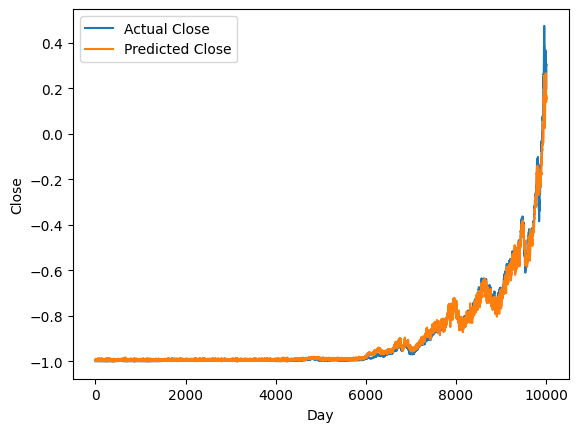

In [26]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
# Flatten predictions
train_predictions = predicted.flatten()

# Create a dummy array with the same number of features (40) as the scaler was fitted on
dummies = np.zeros((train_predictions.shape[0], 40))  # 40 is the original number of features in the scaled data
dummies[:, 0] = train_predictions  # Assuming the Close_Price is in the first column

# Perform inverse transformation
dummies = scaler.inverse_transform(dummies)

# Extract the first column, which corresponds to the inverse-transformed predictions for Close_Price
train_predictions = dummies[:, 0].copy()
train_predictions


array([  0.64689022,   0.56721218,   0.59705417, ..., 105.46975679,
       104.87837525, 105.08710102])

In [28]:
# Create a dummy array with the same number of features as the scaler was originally fitted on (e.g., 40 columns)
dummies = np.zeros((y_train.shape[0], 40))  # 40 is the original number of features
dummies[:, 0] = y_train.flatten()  # Assuming the Close_Price is in the first column

# Perform inverse transformation
dummies = scaler.inverse_transform(dummies)

# Extract the first column, which corresponds to the inverse-transformed y_train
new_y_train = dummies[:, 0].copy()
new_y_train


array([1.15515307e-01, 1.14398199e-01, 1.05466753e-01, ...,
       1.14949998e+02, 1.19029999e+02, 1.18690002e+02])

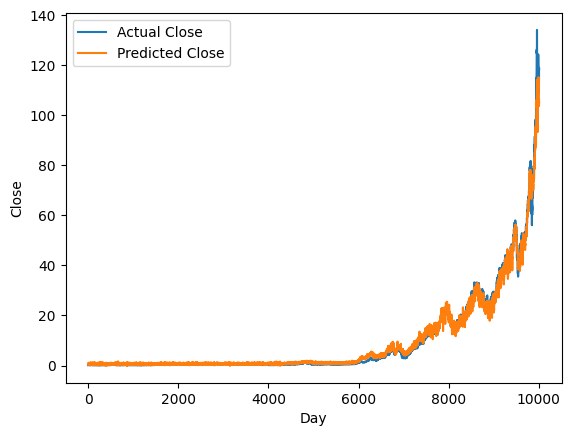

In [29]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [30]:
# Generate predictions
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

# Create a dummy array with the same number of features as the scaler was originally fitted on (e.g., 40 columns)
dummies = np.zeros((X_test.shape[0], 40))  # 40 is the original number of features
dummies[:, 0] = test_predictions  # Assuming Close_Price is in the first column

# Perform inverse transformation
dummies = scaler.inverse_transform(dummies)

# Extract the first column, which corresponds to the inverse-transformed predictions for Close_Price
test_predictions = dummies[:, 0].copy()
test_predictions


array([103.29161746, 106.16696539, 109.66515014, 112.10871934,
       112.19219609, 111.52046679, 111.74277681, 112.62893944,
       114.31706941, 116.22852619, 112.68919551, 111.54725299,
       109.88072497, 108.90163356, 112.70662458, 112.07202558,
       110.3261476 , 109.51165346, 110.61538111, 113.26100867,
       116.45875901, 116.10760732, 114.62640544, 115.71042101,
       116.37495146, 118.29328172, 118.17132437, 116.62455202,
       116.39159421, 116.70373115, 119.35190475, 119.91167646,
       119.25916034, 119.8420524 , 118.33772474, 118.95149455,
       120.60191397, 119.72827272, 120.5221112 , 118.59371613,
       116.08630634, 117.66239195, 115.21447633, 114.71348297,
       114.10264422, 112.57598253, 113.75006361, 112.26582222,
       112.49331107, 114.1666258 , 114.51454817, 115.86231523,
       116.92304776, 119.05738125, 122.19519004, 121.27145243,
       123.33400357, 124.471014  , 122.04803268, 120.53784834,
       118.69111878, 119.00131433, 120.16751872, 118.37

In [33]:
# Create a dummy array with 40 columns to match the scaler's expected input shape
dummies = np.zeros((y_test.shape[0], 40))  # 40 is the original number of features the scaler was fitted on
dummies[:, 0] = y_test.flatten()  # Place y_test in the first column, assuming Close_Price is in the first column

# Perform inverse transformation
dummies = scaler.inverse_transform(dummies)

# Extract the first column, which corresponds to the inverse-transformed y_test
new_y_test = dummies[:, 0].copy()


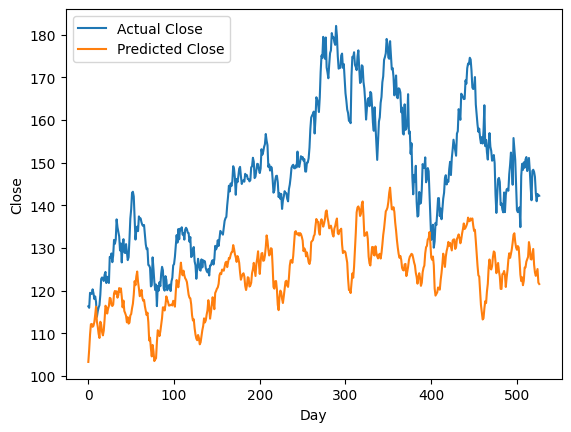

In [34]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
